In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [4]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [5]:
data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])    
}

In [6]:
data_dir = 'data/hymenoptera_data'

In [7]:
dataset_list = ['train', 'val']
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                 for x in dataset_list}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in dataset_list}

dataset_sizes = {x: len(image_datasets[x]) for x in dataset_list}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['ants', 'bees']


In [8]:
print(image_datasets.keys())
print(image_datasets.values())
print('========================')
print(image_datasets['train'].classes)

dict_keys(['train', 'val'])
dict_values([Dataset ImageFolder
    Number of datapoints: 244
    Root location: data/hymenoptera_data\train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
           ), Dataset ImageFolder
    Number of datapoints: 153
    Root location: data/hymenoptera_data\val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
           )])
['ants', 'bees']


In [9]:
def imshow(inp, title):
    inp = inp.numpy().transpose((1,2,0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

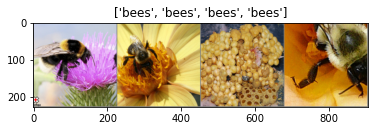

In [10]:
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
def train_model(model, citerion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in dataset_list:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                lables = labels.to(device)
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        
                # 성과 측정
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # 모델을 deepcopy한다.
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # best 모델 가중치 load
    model.load_state_dict(best_model_wts)
    return model

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # 성과측정
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 deepcopy한다.
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # best 모델 가중치 load
    model.load_state_dict(best_model_wts)
    return model

## Pretrain 모델 로드

In [13]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
print(num_ftrs)

512


In [14]:
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [16]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6510 Acc: 0.5984
val Loss: 0.4811 Acc: 0.7712

Epoch 1/24
----------
train Loss: 0.5123 Acc: 0.7705
val Loss: 0.3284 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.4720 Acc: 0.7787
val Loss: 0.2757 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.4719 Acc: 0.8074
val Loss: 0.2443 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.3947 Acc: 0.8238
val Loss: 0.2397 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.3804 Acc: 0.8484
val Loss: 0.2047 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.3378 Acc: 0.8730
val Loss: 0.1950 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3446 Acc: 0.8525
val Loss: 0.1854 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3833 Acc: 0.8033
val Loss: 0.1884 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.4041 Acc: 0.8156
val Loss: 0.1994 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.4038 Acc: 0.8033
val Loss: 0.1953 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3758 Acc: 0.8074
val Loss: 0.1919 Acc: 0.9346

Ep

In [17]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

In [18]:
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                        exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6478 Acc: 0.6721
val Loss: 0.2297 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.3768 Acc: 0.8361
val Loss: 0.1888 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.3905 Acc: 0.8238
val Loss: 0.1998 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.4260 Acc: 0.7992
val Loss: 0.2243 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.4940 Acc: 0.8197
val Loss: 0.3778 Acc: 0.8497

Epoch 5/24
----------
train Loss: 0.3952 Acc: 0.8361
val Loss: 0.5704 Acc: 0.7908

Epoch 6/24
----------
train Loss: 0.4860 Acc: 0.8033
val Loss: 0.2343 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3078 Acc: 0.8770
val Loss: 0.2453 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3047 Acc: 0.8525
val Loss: 0.2755 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3491 Acc: 0.8689
val Loss: 0.2190 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.4169 Acc: 0.8361
val Loss: 0.2598 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.4312 Acc: 0.8279
val Loss: 0.2712 Acc: 0.9150

Ep